In [31]:
"""
Created on Mon Sep 18 22:28:01 2023

@author: merle
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pch
import plotly.express as px
import plotly.graph_objects as go
import nbformat
import os
from glob import glob
import scipy
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('PCA_paper_stylesheet.mplstyle')


#choose if sub dwarfs be included in plot:

<span style="color:#c44d6d">


#### To do when using this notebook:

1. Put in names of targets as found in UltracoolSheet.csv
2. Choose to incl. or excl. subdwarfs and exoplanets in the plot ('Sd')


</span>

In [13]:
showSubdwarfs = True
showExoplanets = True
plot_unc = True
incl_refs = True

In [66]:
simp0136 = 'SIMP J013656.5+093347.3'
simp0136_label = 'J0136'

inspected = [simp0136]
inspectLabel = [simp0136_label]
inspectColor = ['#4df356', 'forestgreen', 'deepskyblue','slateblue','tomato','darkred'] #assign each target with custom color

In [54]:

# File path and URL
file_path = 'UltracoolSheet.csv'
url = "https://zenodo.org/records/10573247/files/UltracoolSheet%20-%20Main.csv?download=1"

# Check if file exists locally
if os.path.exists(file_path):
    # Load the CSV from the local file
    ultracool = pd.read_csv(file_path)
    print(f"Loaded data from local file: {file_path}")
else:
    # Download and load the CSV from the URL
    ultracool = pd.read_csv(url)
    print(f"Downloaded data from URL: {url}")

print(ultracool.head())



Downloaded data from URL: https://zenodo.org/records/10573247/files/UltracoolSheet%20-%20Main.csv?download=1
                        name               name_simbadable  \
0   ULAS J000010.43+113602.2      ULAS J000010.43+113602.2   
1   SDSS J000013.54+255418.6       2MASS J00001354+2554180   
2      PSO J000.2794+16.6237  Gaia DR2 2772504778021649152   
3   SDSS J000112.18+153535.5       2MASS J00011217+1535355   
4  WISEA J000131.93-084126.9       2MASS J00013166-0841234   

                ref_discovery  ra_j2000_formula  dec_j2000_formula  \
0                      Card15            0.0432            11.6020   
1                      Knap04            0.0565            25.9050   
2  Alle16b;Reyl18-phot;Sang23            0.2792            16.6241   
3                      Knap04            0.3007            15.5932   
4                     Luhm14c            0.3820            -8.6900   

  source_j2000_formula  glon_j2000  glat_j2000 literature_flag  \
0              CatWISE    103.4

In [55]:

#exclude all rows where plx_formula AND dist are nan and all columns that are irrelevant
columns_to_keep = [
    'name', 'exoplanet', 'J_MKO', 'K_MKO', 'H_MKO', 'plx_formula', 'dist_formula', 'sptnum_formula',
    'Jerr_MKO', 'Kerr_MKO', 'plxerr_formula', 'disterr_formula',
    'ref_J_MKO', 'ref_K_MKO', 'ref_plx_formula', 'dist_formula_source'
]
uc = pd.DataFrame(ultracool, columns=columns_to_keep)
uc = uc[~(uc['dist_formula'].isna() & uc['plx_formula'].isna())]  # Deletes rows where both dist_formula and plx_formula are NaN
uc['plx_formula'] /= 1000 #convert parallax to mas as in uc
uc['plxerr_formula'] /= 1000 #convert parallax to mas as in uc

def absMagPlx(mag, plx):
    Mag = mag + 5*(1+np.log10(plx))
    return Mag


def absMagDist(mag, dist):
    Mag = mag - 5*(np.log10(dist)-1)
    return Mag

In [56]:

if showSubdwarfs == False:
    uc.drop(uc[uc['sptnum_formula'] < 0].index, inplace = True)

#color: J_MKO - K_MKO:
uc['color'] = uc['J_MKO'] - uc['K_MKO']

# Calculate absolute magnitude based on the condition of 'plx_formula' being NaN or not
uc['absMag'] = np.where(
    uc['plx_formula'].notna(),  # Condition: if 'plx_formula' is not NaN
    absMagPlx(uc['J_MKO'], uc['plx_formula']),  # TRUE: Use absMagPlx when plx_formula is available (uses Plx to calc absMag)
    absMagDist(uc['J_MKO'], uc['dist_formula'])  # FALSE: Use absMagDist when plx_formula is NaN (uses Dist to calc absMag))
)

# Color error (J-K)
uc['color_err'] = np.sqrt(uc['Jerr_MKO']**2 + uc['Kerr_MKO']**2)

# Absolute magnitude error depending on distance source
uc['absMag_err'] = np.where(
    uc['plx_formula'].notna(),
    5 * uc['plxerr_formula'] / (uc['plx_formula'] * np.log(10)),
    5 * uc['disterr_formula'] / (uc['dist_formula'] * np.log(10))
)


#spectral type and prep colors for plot
spectype_numkey = [
    (uc['sptnum_formula'] < 0),
    (uc['sptnum_formula'] >= 0) & (uc['sptnum_formula'] < 10),
    (uc['sptnum_formula'] >= 10) & (uc['sptnum_formula'] < 20),
    (uc['sptnum_formula'] >= 20) & (uc['sptnum_formula'] < 30),
    (uc['sptnum_formula'] >= 30),
    ] #numerical key to spectral types

specTypes = ['Sd', 'M', 'L', 'T', 'Y']
specColor = ['grey', 'lightcoral', 'crimson', 'dodgerblue', 'mediumorchid']
specCoords = [(0,10.1), (1.2,7.0), (0.5,12.5), (-1,14), (-0.5,24)]

if showSubdwarfs == False:
    spectype_numkey, specTypes, specColor, specCoords = spectype_numkey[1:], specTypes[1:], specColor[1:], specCoords[1:]
    

uc['spectype'] = np.select(spectype_numkey, specTypes, default='unknown')
uc['speccolor'] = np.select(spectype_numkey, specColor, default='black')

#now implement vals of whether or not has exoplanet
uc.loc[uc['exoplanet'].str.contains('\?'), 'exoplanet'] = '1' #all possible exopl = 1 (incl ?)
uc.loc[uc['exoplanet'].str.contains('Y'), 'exoplanet'] = '2' #all definite exopl = 2
uc.loc[uc['exoplanet'].str.contains('N'), 'exoplanet'] = '0' #no exopl = 0
uc['exoplanet'] = uc['exoplanet'].astype(int)

#specType = lambda x: 'Y' if x<0 else 'M' if x>=0 and x<10 else 'L' if x>=10 and x<20 else 'T' if x>=20

Check that all included targets can be found in UltraCool.csv. If not, check spelling against that of the ultracool sheet.

In [57]:
# Check if all inspected target names are in uc['name']
missing_targets = [target for target in inspected if target not in uc['name'].values]

# If there are missing targets, print an error message for each
if missing_targets:
    for target in missing_targets:
        print(f"The target name you have chosen ({target}) can't be found in UltraCool.csv. "
              "\nPlease check the format and spelling of the target's name against the sheet which can be found at: "
              "\nhttps://docs.google.com/spreadsheets/d/1i98ft8g5mzPp2DNno0kcz4B9nzMxdpyz5UquAVhz-U8/edit?usp=sharing")
else:
    print("All inspected targets are found in the dataset.")

All inspected targets are found in the dataset.


In [58]:
target_name = inspected[0]  # use the first inspected target (or loop through if needed)

# Look up the row in the DataFrame
row = uc[uc['name'] == target_name]

if not row.empty:
    plx_mas = row['plx_formula'].values[0]*1e3
    plx_err = row['e_plx_formula'].values[0]*1e3 if 'e_plx_formula' in uc.columns else None
    parallax = (plx_mas, plx_err) if plx_err is not None else (plx_mas,)
    print(f"Using parallax for {target_name}: {parallax[0]:.3f} as")
else:
    raise ValueError(f"Target '{target_name}' not found in DataFrame.")


Using parallax for SIMP J013656.5+093347.3: 163.400 as


### If you want to include custom targets / objects...

You'll require a .dat file structures like this (`wavelength [um]`,`flux [W/m^2/um]`)

In [59]:
custom_objects=True
USE_PARALLAX_FROM_SHEET = False

colors = ["#b99e57", "#5772b9", "#b957a3", '#57b96d']

In [60]:

if custom_objects:
    os.environ["SPECIES_DB_PATH"] = "species_deps"
    from species import SpeciesInit
    from species.phot.syn_phot import SyntheticPhotometry
    # Optional: use a DataFrame like `uc` to get the parallax dynamically
    target_name = "SIMP J013656.5+093347.3"

    # Default parallax in mas (if not using sheet)
    parallax = (163.4478, 0.4629)  # in mas

    if USE_PARALLAX_FROM_SHEET:
        row = uc[uc['name'] == target_name]
        if not row.empty:
            plx_arcsec = row['plx_formula'].values[0]
            plx_err_arcsec = row['e_plx_formula'].values[0]
            parallax = (plx_arcsec * 1000, plx_err_arcsec * 1000)
        else:
            raise ValueError(f"{target_name} not found in DataFrame.")

    SpeciesInit()

    # Prepare photometry filters
    synphot_j = SyntheticPhotometry('MKO/NSFCam.J')
    synphot_k = SyntheticPhotometry('MKO/NSFCam.K')

    # Loop through all spectra
    spectra_files = sorted(glob("Spectra/*.dat"))

    j_mags, jk_colors, labels = [], [], []

    for filepath in spectra_files:
        filename = os.path.basename(filepath)
        label = filename.replace("spectrum_", "").replace(".dat", "").replace("_", " ")

        # Load spectrum
        data = np.loadtxt(filepath, skiprows=1)
        wavelength, flux = data[:, 0], data[:, 1]

        # Compute magnitudes
        j_mag, j_mag_abs = synphot_j.spectrum_to_magnitude(wavelength, flux, error=None, parallax=parallax)
        k_mag, k_mag_abs = synphot_k.spectrum_to_magnitude(wavelength, flux, error=None, parallax=parallax)
        jk_color = j_mag[0] - k_mag[0]

        print(f"{label}:")
        print(f"  Apparent J mag: {j_mag[0]:.3f}")
        print(f"  Apparent K mag: {k_mag[0]:.3f}")
        print(f"  Absolute J mag: {j_mag_abs[0]:.3f}")
        print(f"  Absolute K mag: {k_mag_abs[0]:.3f}")
        print(f"  J–K color: {jk_color:.3f}\n")

        j_mags.append(j_mag_abs[0])
        jk_colors.append(jk_color)
        labels.append(label)


species v0.9.0

Working folder: /Users/merleschrader/Library/Mobile Documents/com~apple~CloudDocs/ColorMagDiagrams

Configuration file: /Users/merleschrader/Library/Mobile Documents/com~apple~CloudDocs/ColorMagDiagrams/species_config.ini
Database file: /Users/merleschrader/Library/Mobile Documents/com~apple~CloudDocs/ColorMagDiagrams/species_database.hdf5
Data folder: /Users/merleschrader/Library/Mobile Documents/com~apple~CloudDocs/ColorMagDiagrams/data

Configuration settings:
   - Database: /Users/merleschrader/Library/Mobile Documents/com~apple~CloudDocs/ColorMagDiagrams/species_database.hdf5
   - Data folder: /Users/merleschrader/Library/Mobile Documents/com~apple~CloudDocs/ColorMagDiagrams/data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed


### Static/fixed plot to exports to png if required

The following section produces a plot that, if required, can be exported as a *.png file. 

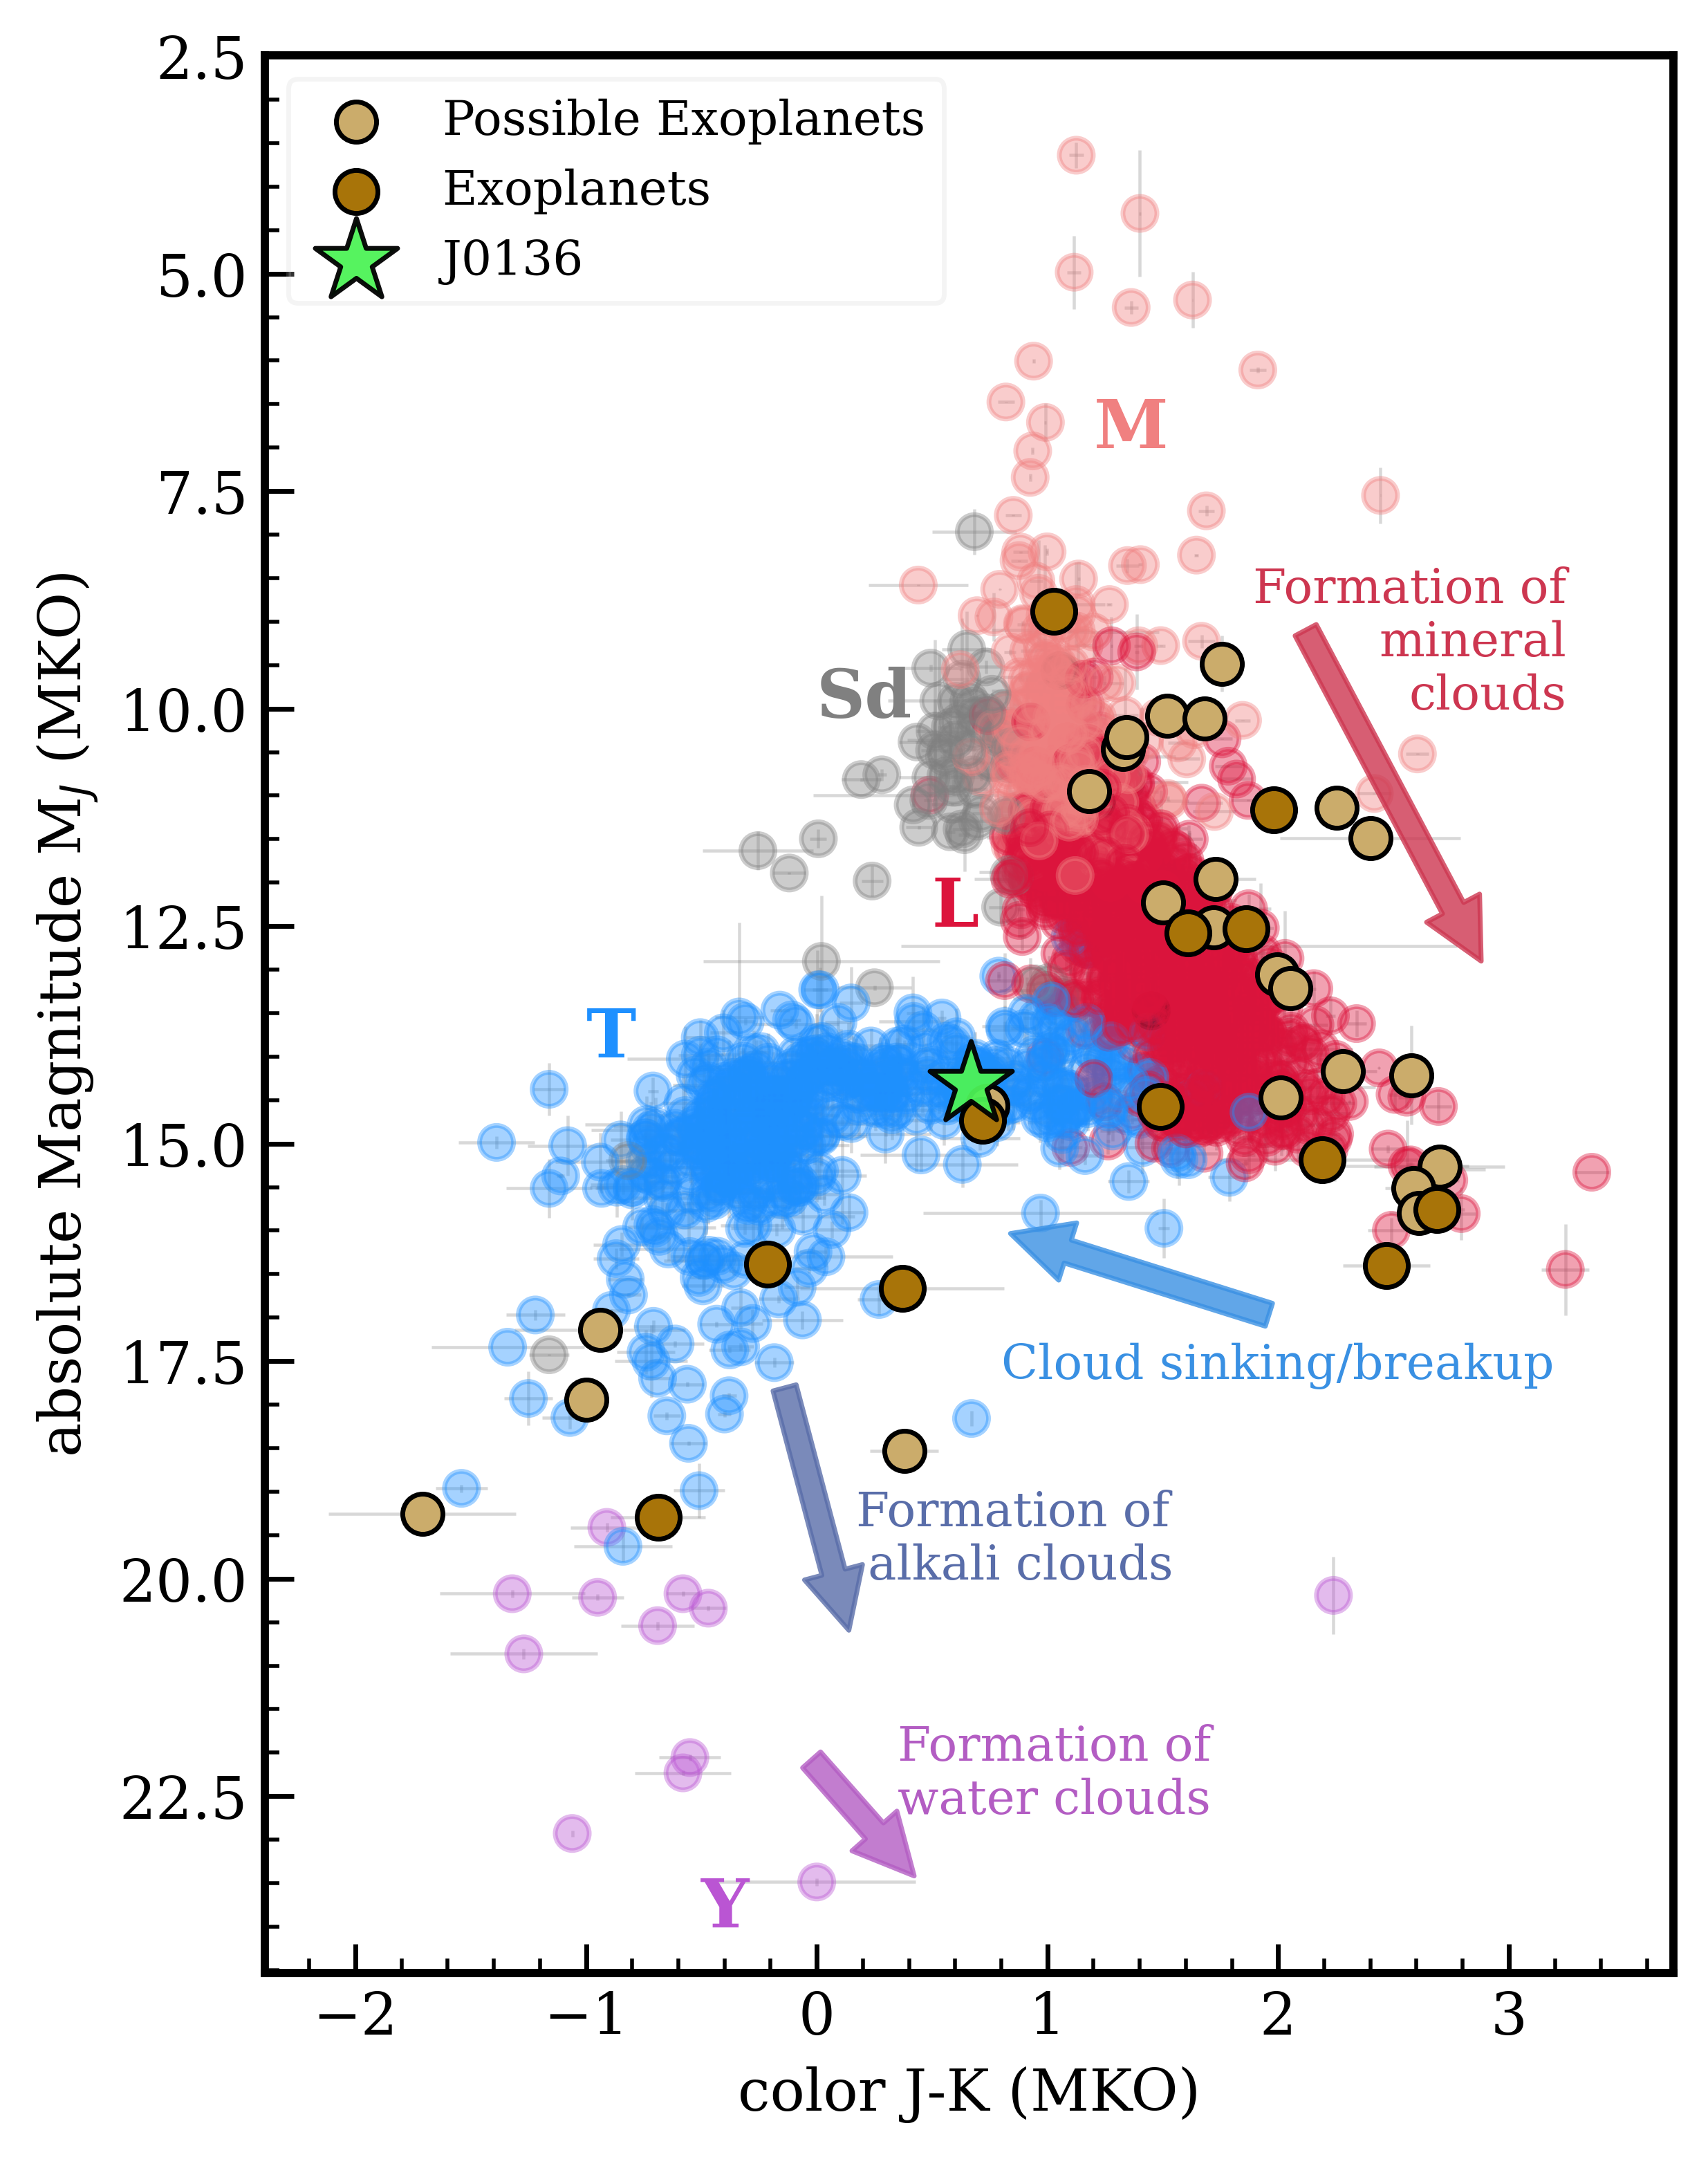

In [71]:

#scatter plot:
plt.figure(figsize=(5.1, 6.4), dpi=500) #5.1, 6.6
  
#plt.title('Color Magnitude (HRD) \nof Ultracool Field Dwarfs')
plt.xlabel('color J-K (MKO)')
plt.ylabel(r'absolute Magnitude M$_J$ (MKO)')

#plot brown dwarfs
plt.scatter(x=uc['color'][uc.exoplanet == 0],y=uc['absMag'][uc.exoplanet == 0],s=50,c=uc['speccolor'][uc.exoplanet == 0],alpha=0.4,marker='o')
if plot_unc:
    plt.errorbar(
        uc['color'][uc.exoplanet == 0],
        uc['absMag'][uc.exoplanet == 0],
        xerr=uc['color_err'][uc.exoplanet == 0],
        yerr=uc['absMag_err'][uc.exoplanet == 0],
        fmt='none', ecolor='gray', alpha=0.3, zorder=0, lw=0.65
    )

if showExoplanets==True:
    #plot possible exoplanets
    plt.scatter(x=uc['color'][uc.exoplanet == 1],y=uc['absMag'][uc.exoplanet == 1],s=70,c='#cbac6b',alpha=1.0,marker='o',edgecolors='k', label="Possible Exoplanets")
    #plot exoplanets
    plt.scatter(x=uc['color'][uc.exoplanet == 2],y=uc['absMag'][uc.exoplanet == 2],s=80,c='#a87409',alpha=1.0,marker='o',edgecolors='k', label="Exoplanets")
    if plot_unc:
        plt.errorbar(
            uc['color'][uc.exoplanet == 1],
            uc['absMag'][uc.exoplanet == 1],
            xerr=uc['color_err'][uc.exoplanet == 1],
            yerr=uc['absMag_err'][uc.exoplanet == 1],
            fmt='none', ecolor='gray', alpha=0.3, zorder=0, lw=0.65
        )
        plt.errorbar(
            uc['color'][uc.exoplanet == 2],
            uc['absMag'][uc.exoplanet == 2],
            xerr=uc['color_err'][uc.exoplanet == 2],
            yerr=uc['absMag_err'][uc.exoplanet == 2],
            fmt='none', ecolor='gray', alpha=0.3, zorder=0, lw=0.65
        )


#plot objects to be inspected
for case,label,color in zip(inspected,inspectLabel,inspectColor):
    plt.scatter(x=uc['color'][uc.name == case], y=uc['absMag'][uc.name == case], s=325, c=color,alpha=0.95, edgecolors='k', label=label, marker='*')
    if plot_unc:
        plt.errorbar(
            uc['color'][uc.name == case],
            uc['absMag'][uc.name == case],
            xerr=uc['color_err'][uc.name == case],
            yerr=uc['absMag_err'][uc.name == case],
            fmt='none', ecolor='gray', alpha=0.3, zorder=0
        )


#annotate spectral types
for (stype, coord, scolor) in zip(specTypes, specCoords, specColor):
    plt.annotate(stype, xy = coord, fontsize=14, color = scolor, fontweight = 'bold')

#if you'd like: add custom object(s):
if custom_objects:
    for j_mag, jk_color, color, label in zip(j_mags, jk_colors, colors, labels):
        plt.scatter(x=jk_color, y=j_mag, s=50, c=color, alpha=1, edgecolors='k', label=label, marker='x')

#arrows and cloud formation annotation:
arrowstart = [(2.1, 9),(2, 17),(-0.15, 17.7),(-0.05, 22)]
arrowstop = [(2.9,13),(0.8,16),(0.15,20.7),(0.45,23.5)]
arrowcolors = ['#cd3650','#3990e3','#596da9','#b35dc3']
for start,stop,color in zip(arrowstart,arrowstop,arrowcolors):
    arrow=pch.FancyArrowPatch(start, stop, mutation_scale=25, alpha=0.8, color=color)
    plt.gca().add_patch(arrow)
    
labelCoords = [(3.25,10), (0.8,17.7), (0.85,20), (0.35,22.7)]
labelWords = ['Formation of\nmineral\nclouds', 'Cloud sinking/breakup', 'Formation of\n alkali clouds', 'Formation of \nwater clouds']
labelAlign = ['right', 'left', 'center', 'left']
for (label, coord, color, align) in zip(labelWords, labelCoords, arrowcolors, labelAlign):
    plt.annotate(label, xy = coord, fontsize=10, color = color, ha=align)

plt.gca().invert_yaxis()
plt.legend(framealpha=0.2, loc='upper left') #loc='upper right'
plt.tight_layout()
plt.savefig(f"Images/ColorMagUC_{'-'.join(inspectLabel)}.png", bbox_inches='tight')
plt.show()



### Interactive Plot

The following piece of code produces an interactive plot that allows hovering over plotted points to see the targets name, colour and absolute magnitude. This can help when looking for targets that are of similar colour and magnitude as those plotted.

<span style="color:#c44d6d">

You can chose to annotate cloud development details, as annotated on the png plot above. This is not recommended, as it may get in the way of zooming/hovering over the plot. 

</span>

In [26]:
annotateCloudDevs=False
add_custom_point=True

In [ ]:
def format_references(row):
    refs = []
    if incl_refs:
        refs.append(f"<i>J Ref:</i> {row['ref_J_MKO']}" if pd.notna(row['ref_J_MKO']) else "")
        refs.append(f"<i>K Ref:</i> {row['ref_K_MKO']}" if pd.notna(row['ref_K_MKO']) else "")
        if pd.notna(row['plx_formula']):
            refs.append(f"<i>Parallax Ref:</i> {row['ref_plx_formula']}" if pd.notna(row['ref_plx_formula']) else "")
        elif pd.notna(row['dist_formula']):
            refs.append(f"<i>Distance Ref:</i> {row['dist_formula_source']}" if pd.notna(row['dist_formula_source']) else "")
    return "<br>".join(filter(None, refs))  # Remove empty strings


# Function to add scatter traces to Plotly figure
fig = go.Figure()

# Function to add scatter traces to Plotly figure
def add_scatter_trace(x, y, size, color, opacity, label, hover_text, edgecolor=None, marker_symbol=None, x_err=None, y_err=None):
    fig.add_trace(go.Scatter(
        x=x, y=y,
        mode='markers',
        marker=dict(
            size=size, color=color, opacity=opacity,
            line=dict(width=1, color=edgecolor) if edgecolor else None,
            symbol=marker_symbol
        ),
        name=label,
        text=hover_text,
        hoverinfo="text",
        error_x=dict(
            type='data',
            array=x_err,
            visible=plot_unc,
            thickness=0.65
        ) if x_err is not None else None,
        error_y=dict(
            type='data',
            array=y_err,
            visible=plot_unc,
            thickness=0.65
        ) if y_err is not None else None,
        showlegend=True
    ))

# Add brown dwarfs by spectral type
for spec_type, color in zip(specTypes, specColor):
    mask = (uc.exoplanet == 0) & (uc['spectype'] == spec_type) & (~uc['name'].isin(inspected))

    add_scatter_trace(
        x=uc['color'][mask],
        y=uc['absMag'][mask],
        x_err=uc['color_err'][mask] if plot_unc else None,
        y_err=uc['absMag_err'][mask] if plot_unc else None,
        size=12,
        color=color,
        opacity=0.4,
        label=f'{spec_type} Dwarfs',
        hover_text=[
            (
                f"<b>{row['name']}</b><br>"
                f"Color: {row['color']:.2f} ± {row['color_err']:.2f}<br>"
                f"Abs Mag: {row['absMag']:.2f} ± {row['absMag_err']:.2f}<br>"
                f"{format_references(row)}"
            )
            for _, row in uc[mask].iterrows()
        ]

    )

if showExoplanets==True:
    # Add possible exoplanets
    add_scatter_trace(
        uc['color'][uc.exoplanet == 1],
        uc['absMag'][uc.exoplanet == 1],
        x_err=uc['color_err'][uc.exoplanet == 1] if plot_unc else None,
        y_err=uc['absMag_err'][uc.exoplanet == 1] if plot_unc else None,
        size=14,
        color='#cbac6b',
        opacity=1.0,
        label="Possible Exoplanets",
        hover_text=[
            (
                f"<b>{row['name']}</b><br>"
                f"Color: {row['color']:.2f}" + (f" ± {row['color_err']:.2f}" if plot_unc and pd.notna(row.get('color_err')) else "") + "<br>"
                f"Abs Mag: {row['absMag']:.2f}" + (f" ± {row['absMag_err']:.2f}" if plot_unc and pd.notna(row.get('absMag_err')) else "") + "<br>"
                f"{format_references(row)}"
            )
            for _, row in uc[uc.exoplanet == 1].iterrows()
        ],
        edgecolor="black"
    )

    # Add exoplanets
    add_scatter_trace(
        uc['color'][uc.exoplanet == 2],
        uc['absMag'][uc.exoplanet == 2],
        x_err=uc['color_err'][uc.exoplanet == 2] if plot_unc else None,
        y_err=uc['absMag_err'][uc.exoplanet == 2] if plot_unc else None,
        size=16,
        color='#a87409',
        opacity=1.0,
        label="Exoplanets",
        hover_text=[
            (
                f"<b>{row['name']}</b><br>"
                f"Color: {row['color']:.2f}" + (f" ± {row['color_err']:.2f}" if plot_unc and pd.notna(row.get('color_err')) else "") + "<br>"
                f"Abs Mag: {row['absMag']:.2f}" + (f" ± {row['absMag_err']:.2f}" if plot_unc and pd.notna(row.get('absMag_err')) else "") + "<br>"
                f"{format_references(row)}"
            )
            for _, row in uc[uc.exoplanet == 2].iterrows()
        ],
        edgecolor="black"
    )

# Add inspected objects
for case, label, color in zip(inspected, inspectLabel, inspectColor):
    add_scatter_trace(
        uc['color'][uc.name == case],
        uc['absMag'][uc.name == case],
        x_err=uc['color_err'][uc.name == case] if plot_unc else None,
        y_err=uc['absMag_err'][uc.name == case] if plot_unc else None,
        size=18,
        color=color,
        opacity=0.95,
        label=label,
        hover_text=[
            (
                f"<b>{row['name']}</b><br>"
                f"Color: {row['color']:.2f}" + (f" ± {row['color_err']:.2f}" if plot_unc and pd.notna(row.get('color_err')) else "") + "<br>"
                f"Abs Mag: {row['absMag']:.2f}" + (f" ± {row['absMag_err']:.2f}" if plot_unc and pd.notna(row.get('absMag_err')) else "") + "<br>"
                f"{format_references(row)}"
            )
            for _, row in uc[uc.name == case].iterrows()
        ],
        edgecolor="black",
        marker_symbol='star'
    )


# Customize layout
fig.update_layout(
    title="Color Magnitude of Ultracool Dwarfs and Exoplanets",
    xaxis_title="Color J-K (MKO)",
    yaxis_title="Absolute Magnitude M<sub>J</sub> (MKO)",
    template='plotly_white',
    autosize=False,
    width=800,
    height=800,
    legend=dict(
        traceorder='normal',
        font=dict(
            size=12,),
    ),
)

# Invert y-axis to mimic HR diagram style
fig.update_yaxes(autorange="reversed")

if custom_objects:
    for j_mag, jk_color, color, label in zip(j_mags, jk_colors, colors, labels):
        add_scatter_trace(
            x=[jk_color],
            y=[j_mag],
            size=14,
            color=color,
            opacity=1.0,
            label=label,
            hover_text=[
                f"<b>{label}</b><br>Color: {jk_color:.2f}<br>Abs Mag: {j_mag:.2f}"
            ],
            edgecolor="black",
            marker_symbol='x'
        )

if annotateCloudDevs==True:
    # Add arrows for annotations
    for start, stop, color in zip(arrowstart, arrowstop, arrowcolors):
        fig.add_annotation(
            x=stop[0],
            y=stop[1],
            ax=start[0],
            ay=start[1],
            xref="x",
            yref="y",
            axref="x",
            ayref="y",
            showarrow=True,
            arrowhead=2,
            arrowsize=1,
            arrowwidth=1,
            arrowcolor=color,
        )

    # Add annotations for cloud formation
    for (label, coord, color, align) in zip(labelWords, labelCoords, arrowcolors, labelAlign):
        fig.add_annotation(
            x=coord[0],
            y=coord[1],
            text=label,
            showarrow=False,
            font=dict(color=color, size=11),
            align=align
        )

if add_custom_point:  
    # Define properties of the point
    J_mag = 14.385
    K_mag = 13.665
    color_val = J_mag - K_mag
    color_err = np.sqrt(0.006**2 + 0.006**2)
    absMag_err = 0.006  

    hover_text = (
        f"<b>Custom Target</b><br>"
        f"Color: {color_val:.3f} ± {color_err:.3f}<br>"
        f"Abs Mag: {J_mag:.3f} ± {absMag_err:.3f}<br>"
    )
    
    # Example coordinates of your point
    target_x = color_val     # J–K color
    target_y = J_mag    # Absolute J magnitude

    add_scatter_trace(
        x=[color_val],
        y=[J_mag],
        size=14,
        color='hotpink',
        opacity=1.0,
        label="Custom Entry",
        hover_text=[hover_text],
        edgecolor='black',
        marker_symbol='x',
        x_err=[color_err] if plot_unc else None,
        y_err=[absMag_err] if plot_unc else None
    )

fig.write_html(f"Images/Interactive_ColorMagUC_{'-'.join(inspectLabel)}.html")
fig.show()